In [3]:
# Here we calculate mass gaps. Read in combined galaxy/mass/stelkin table
import astropy.io.fits as fits
import numpy as np
from astropy.table import unique,Table,setdiff,hstack,join
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

massGapData = Table.read('/suphys/fscu5535/python_scripts/mod_data/ImprovedDataMassGapMethod3.fits',memmap=True)
massGapData.info()
print(massGapData)

<Table length=2716>
    name     dtype     unit      class     n_bad
----------- ------- --------- ------------ -----
     CATAID   int64           MaskedColumn     0
    GroupID   int32           MaskedColumn     0
RankIterCen   int16           MaskedColumn     0
   logmstar float32 dex(Msun)       Column     0
 LAMBDAR_RE float64                 Column  2076
 CATAID GroupID RankIterCen  logmstar     LAMBDAR_RE    
                            dex(Msun)                   
------- ------- ----------- --------- ------------------
   6837  203007           1   9.82991                nan
   6838  203007           2 9.3911085                nan
   7203  203039           2 10.380958                nan
   7206  203039           1 10.410899 0.5493758320808411
   7289  203048           1 11.081309 0.0719321072101593
   7293  203048           2  9.731596                nan
    ...     ...         ...       ...                ...
3634416  101283           4  9.093014                nan
3634544  1

598 mass gaps calculated!
0 negative mass gaps found
0 unusual mass gaps due to missing logmstar data for one or both galaxies ignored
massGapMethod3 written to file.


Text(0, 0.5, 'Frequency')

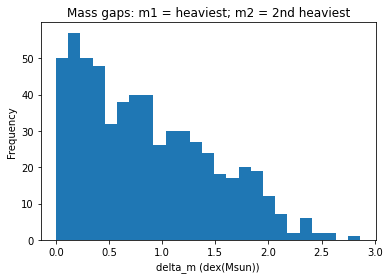

In [4]:
# Method 3: mass gap between two heaviest galaxies. First group by GroupID and sort by GroupID followed
# by logmstar. Sorting by logmstar appears to sort in ascending order
massGapDataGrouped = massGapData.group_by('GroupID')
massGapDataGrouped.sort(['GroupID','logmstar'])

# Store the mass gap and GroupID for each group, later we will convert to a table
groupid = list()
groupMassGap = list()
unusualMassGaps = 0
m1list = list()
m2list = list()
m1lambda = list()
m1CATAID = list()
m2CATAID = list()

# Loop over all groups
for i in range(len(massGapDataGrouped.groups)):
    
    # Now calculate the mass gap and store it as well as the corresponding GroupID. They are the last two
    # masses in the group when sorted by logmstar
    m1 = massGapDataGrouped.groups[i]['logmstar'][len(massGapDataGrouped.groups[i])-1]
    m2 = massGapDataGrouped.groups[i]['logmstar'][len(massGapDataGrouped.groups[i])-2]

    # Make sure that these galaxies don't have missing masses (if they do then I've made a mistake reducing
    # the data)
    if m1 != 0 and m2 != 0:  
        massGap = m1 - m2
        groupMassGap.append(massGap)
        groupid.append(massGapDataGrouped.groups[i]['GroupID'][0])
        m1list.append(m1)
        m2list.append(m2)
        m1CATAID.append(massGapDataGrouped.groups[i]['CATAID'][len(massGapDataGrouped.groups[i])-1])
        m2CATAID.append(massGapDataGrouped.groups[i]['CATAID'][len(massGapDataGrouped.groups[i])-2])
        m1lambda.append(massGapDataGrouped.groups[i]['LAMBDAR_RE'][len(massGapDataGrouped.groups[i])-1])
    else:
        unusualMassGaps += 1
        
print(len(groupid),"mass gaps calculated!")

# See how many mass gaps are negative and how many are unusually high
negMassGaps = 0
for i in range(len(groupMassGap)):
    if groupMassGap[i] < 0:
        negMassGaps += 1
print(negMassGaps,"negative mass gaps found")
print(unusualMassGaps,"unusual mass gaps due to missing logmstar data for one or both galaxies ignored")

# Convert results to table and write to file
massGapMethod3 = Table()
massGapMethod3['GroupID'] = groupid
massGapMethod3['m1_CATAID'] = m1CATAID
massGapMethod3['m2_CATAID'] = m2CATAID
massGapMethod3['m1'] = m1list
massGapMethod3['m2'] = m2list
massGapMethod3['deltaM'] = groupMassGap
massGapMethod3['m1_LAMBDAR_RE'] = m1lambda
massGapMethod3.write('/suphys/fscu5535/python_scripts/mod_data/ImprovedmassGapMethod3Results.fits',format='fits',overwrite=True)
print("massGapMethod3 written to file.")

# Histogram of results
massGapHist = plt.hist(massGapMethod3['deltaM'],bins=25)
plt.title("Mass gaps: m1 = heaviest; m2 = 2nd heaviest")
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("Frequency")

In [5]:
massGapMethod3.info()
print(massGapMethod3)

<Table length=598>
     name      dtype  n_bad
------------- ------- -----
      GroupID   int32     0
    m1_CATAID   int64     0
    m2_CATAID   int64     0
           m1 float32     0
           m2 float32     0
       deltaM float32     0
m1_LAMBDAR_RE float64   145
GroupID m1_CATAID m2_CATAID     m1         m2      deltaM      m1_LAMBDAR_RE   
------- --------- --------- ---------- --------- ---------- -------------------
 100006    372123    301599  11.250554 10.834722 0.41583252 0.11300508677959442
 100017    214250    214258  11.398453 11.046007  0.3524456 0.22132542729377747
 100025    381206    381207  11.208971 10.540119 0.66885185 0.13530147075653076
 100044    551505    205085  11.279909 11.166551  0.1133585  0.3202318847179413
 100055    517205    517211 11.1386385 10.676239 0.46239948 0.08385287970304489
 100067    279878    373168  11.221332   11.0825 0.13883114 0.09192488342523575
 100072    417440    417441  11.093162 10.669486 0.42367554 0.13033363223075867
    ...  

Text(0, 0.5, 'Frequency')

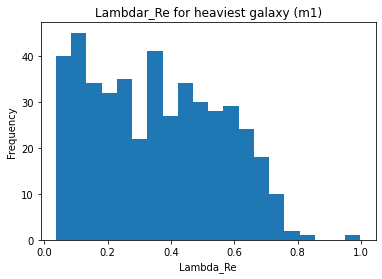

In [11]:
LambdarHist = plt.hist(massGapMethod3['m1_LAMBDAR_RE'],bins=20)
plt.title("Lambdar_Re for heaviest galaxy (m1)")
plt.xlabel("Lambda_Re")
plt.ylabel("Frequency")

Text(0, 0.5, 'Lambdar_Re')

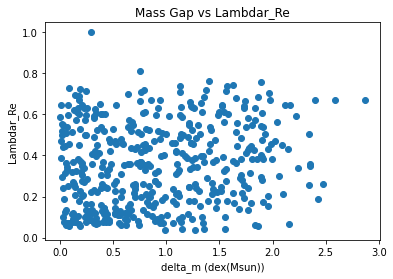

In [13]:
# MassGap vs Lambdar_Re scatter plot
massGapLambdaScatter = plt.scatter(massGapMethod3['deltaM'],massGapMethod3['m1_LAMBDAR_RE'])
plt.title("Mass Gap vs Lambdar_Re")
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("Lambdar_Re")

In [41]:
# Great! Now read in G3CFoF group data, extract relevant columns and left join with massGapMethod3
import math

groupData = Table.read('/suphys/fscu5535/python_scripts/raw_data/G3CFoFGroupv10.fits',memmap=True)
groupDataRel = hstack(groupData['GroupID','Nfof','MassA'])

combinedData = join(massGapMethod3,groupDataRel,keys='GroupID',join_type='left')

# take log of halo mass data and replace existing column. Some groups (46, with multiplicity 2 and 3)
# have zero halo mass recorded, so ignore these. We then do a left join to only keep good groups
log10halomass = list()
goodGroupIDs = list()
for i in range(len(combinedData)):
    if combinedData[i]['MassA'] > 0:
        log10halomass.append(math.log10(combinedData[i]['MassA']))
        goodGroupIDs.append(combinedData[i]['GroupID'])
        
goodHalomassGroups = Table()
goodHalomassGroups['GroupID'] = goodGroupIDs
goodHalomassGroups['log(MassA)'] = log10halomass
combinedGoodHalomassGroupsData = join(goodHalomassGroups,combinedData,keys='GroupID',join_type='left')

# Calculate logMassA/m1 for each group and store in new column
halomassToM1 = list()
for i in range(len(combinedGoodHalomassGroupsData)):
    ratio = combinedGoodHalomassGroupsData[i]['log(MassA)']/combinedData[i]['m1']
    halomassToM1.append(ratio)
    
combinedGoodHalomassGroupsData['log(MassA)/m1'] = halomassToM1

combinedGoodHalomassGroupsData.info()
print(combinedGoodHalomassGroupsData[0])

<Table length=552>
     name      dtype   unit     class     n_bad
------------- ------- ------ ------------ -----
      GroupID   int32        MaskedColumn     0
   log(MassA) float64              Column     0
    m1_CATAID   int64              Column     0
    m2_CATAID   int64              Column     0
           m1 float32              Column     0
           m2 float32              Column     0
       deltaM float32              Column     0
m1_LAMBDAR_RE float64              Column   120
         Nfof   int16        MaskedColumn     0
        MassA float32 Msun/h       Column     0
log(MassA)/m1 float64              Column     0
GroupID     log(MassA)     m1_CATAID m2_CATAID     m1        m2      deltaM      m1_LAMBDAR_RE    Nfof       MassA         log(MassA)/m1   
                                                                                                             Msun/h                        
------- ------------------ --------- --------- --------- --------- ----------

In [86]:
# Write to file:
combinedGoodHalomassGroupsData.write('/suphys/fscu5535/python_scripts/mod_data/massGaps3.0.fits',overwrite=True)

Text(0, 0.5, 'log(MassA)/m1')

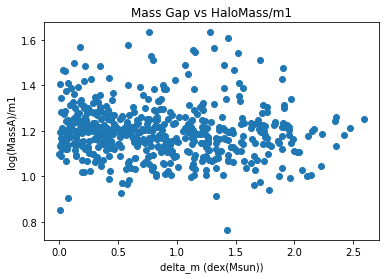

In [44]:
# Plot mass gaps against halomass/m1
massGapHalomassToM1 = plt.scatter(combinedGoodHalomassGroupsData['deltaM'],combinedGoodHalomassGroupsData['log(MassA)/m1'])
plt.title("Mass Gap vs HaloMass/m1")
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("log(MassA)/m1")


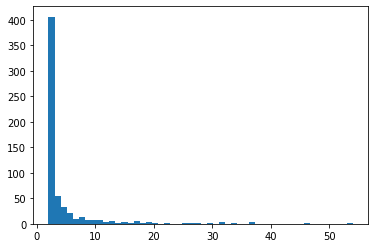

In [52]:
# Plotting mass gaps for different Nfof bins. First look at distribution of Nfof
Nfofdist = plt.hist(combinedData['Nfof'],bins=50)

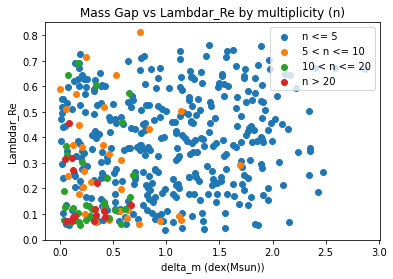

In [85]:
# So try the following bins: (2 <= n1 <= 5),(5 < n2 <= 10), (10 < n3 <= 20), (n4 > 20). First sort the
# combined data into the four Nfof bins

# Store relevant data for each bin in these lists
n1GroupID = list()
n1deltaM = list()
n1Lambdar_Re = list()

n2GroupID = list()
n2deltaM = list()
n2Lambdar_Re = list()

n3GroupID = list()
n3deltaM = list()
n3Lambdar_Re = list()

n4GroupID = list()
n4deltaM = list()
n4Lambdar_Re = list()

# Sort relevant data into Nfof bins
for i in range(len(combinedData)):
    if combinedData[i]['Nfof'] <= 5:
        n1GroupID.append(combinedData[i]['GroupID'])
        n1deltaM.append(combinedData[i]['deltaM'])
        n1Lambdar_Re.append(combinedData[i]['m1_LAMBDAR_RE'])

    if combinedData[i]['Nfof'] > 6 and combinedData[i]['Nfof'] <= 10:
        n2GroupID.append(combinedData[i]['GroupID'])
        n2deltaM.append(combinedData[i]['deltaM'])
        n2Lambdar_Re.append(combinedData[i]['m1_LAMBDAR_RE'])

    if combinedData[i]['Nfof'] > 10 and combinedData[i]['Nfof'] <= 20:
        n3GroupID.append(combinedData[i]['GroupID'])
        n3deltaM.append(combinedData[i]['deltaM'])
        n3Lambdar_Re.append(combinedData[i]['m1_LAMBDAR_RE'])

    if combinedData[i]['Nfof'] > 20:
        n4GroupID.append(combinedData[i]['GroupID'])
        n4deltaM.append(combinedData[i]['deltaM'])
        n4Lambdar_Re.append(combinedData[i]['m1_LAMBDAR_RE'])

# Form tables for each bin and plot        
n1 = Table()
n1['GroupID'] = n1GroupID
n1['deltaM'] = n1deltaM
n1['n1Lambdar_Re'] = n1Lambdar_Re

n2 = Table()
n2['GroupID'] = n2GroupID
n2['deltaM'] = n2deltaM
n2['n1Lambdar_Re'] = n2Lambdar_Re

n3 = Table()
n3['GroupID'] = n3GroupID
n3['deltaM'] = n3deltaM
n3['n1Lambdar_Re'] = n3Lambdar_Re

n4 = Table()
n4['GroupID'] = n4GroupID
n4['deltaM'] = n4deltaM
n4['n1Lambdar_Re'] = n4Lambdar_Re

# Plot the above separately since deltaM scale looks off
n1plot = plt.scatter(n1deltaM, n1Lambdar_Re,)
plt.title("Mass Gap vs Lambdar_Re by multiplicity (n)")
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("Lambdar_Re")

n2plot = plt.scatter(n2deltaM, n2Lambdar_Re)
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("Lambdar_Re")

n3plot = plt.scatter(n3deltaM, n3Lambdar_Re)
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("Lambdar_Re")

n4plot = plt.scatter(n4deltaM, n4Lambdar_Re)
plt.xlabel("delta_m (dex(Msun))")
plt.ylabel("Lambdar_Re")
plt.legend(['n <= 5','5 < n <= 10', '10 < n <= 20', 'n > 20'],loc = 'upper right')

In [73]:
# Analysing halo mass data because Scott said the scale looks off (don't think he saw that it is log(MassA))
print(combinedGoodHalomassGroupsData['GroupID','m1','MassA','log(MassA)','log(MassA)/m1'][0:10])

GroupID     m1           MassA           log(MassA)       log(MassA)/m1   
                         Msun/h                                           
------- ---------- ----------------- ------------------ ------------------
 100006  11.250554 118932000000000.0 14.075298715297198 1.2510760456092813
 100017  11.398453 184044350000000.0  14.26492248538418 1.2514788443005875
 100025  11.208971  24616586000000.0  13.39122782500337 1.1946884149184633
 100044  11.279909 121602910000000.0 14.084943982607037 1.2486753053943531
 100055 11.1386385  51869500000000.0 13.714912044436433 1.2312916025482294
 100067  11.221332  76662415000000.0  13.88458249486675 1.2373382227963663
 100072  11.093162   8373569000000.0 12.922910592910819 1.1649438707155286
 100082  10.953195  42959260000000.0 13.633056803277185  1.244664892614347
 100084  10.999505  13400365000000.0  13.12711663021273 1.1934279386990398
 100086  10.729004   3801387000000.0 12.579942097325143 1.1725172445875343


In [80]:
# Check raw group data
rawDataMass = list()
modDataMass = list()
allGroupMatches = list()
badGroups = list()

for i in range(len(groupData)):   
    found = False    
    for j in range(len(combinedGoodHalomassGroupsData)):
        if groupData[i]['GroupID'] == combinedGoodHalomassGroupsData[j]['GroupID']:
            allGroupMatches.append(groupData[i]['GroupID'])
            found = True           
            if groupData[i]['MassA'] != combinedGoodHalomassGroupsData[j]['MassA']:
                badGroups.append(groupData[i]['GroupID'])
                rawDataMass.append(groupData[i]['MassA'])
                modDataMass.append(combinedGoodHalomassGroupsData[j]['MassA'])              
        if found == True:
            break

print(len(allGroupMatches),"total group matches found")
print(len(badGroups),"bad groups found")
                          

552 total group matches found
0 bad groups found


In [82]:
print(len(combinedData)-len(combinedGoodHalomassGroupsData),"groups with 0 halo mass")

46 groups with 0 halo mass


In [ ]:
# so i've extracted the right data and calculated everything correctly..